In [1]:
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
#%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
import astropy.constants as constants

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import *
from ImageFit import ImageFit
from ChainTool import ChainTool

sys.path.append(dir_KLens)
from KLtool import *
from tfCube2 import GalaxyImage, TFCube

In [2]:
###### set up parameters ######
pars = {}
pars['g1'] = 0.0
pars['g2'] = 0.0
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5


pars['theta_int'] = 0. #np.pi/3.


pars['slitWidth'] = 0.06
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print(refSDSSspec)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist


###### setup slitAngles to major & minor axes ######

eint_thy = cal_e_int(sini=pars['sini'], q_z=pars['aspect'])
eobs_thy = cal_e_obs(e_int=eint_thy, g1=pars['g1'])
theta_obs = cal_theta_obs(g2=pars['g2'], e_int=eint_thy, theta_int=pars['theta_int'])

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

pars['slitAngles'] = np.array([slitAng_major_p, slitAng_minor_p])
#pars['slitAngles'] = np.array([slitAng_major_p])


###### find flux_norm ######

flux_norm = find_flux_norm(pars, R=1.5)
print("flux_norm", flux_norm)

avgFlux_per_pix = avgFlux_in_R_per_pix(pars, flux=flux_norm, R=1.5)
print("avgFlux_per_pix", avgFlux_per_pix)

pars['flux'] = flux_norm

##############################
line_species='Halpha'

2.9999999999999994e-16 erg / (cm2 nm s)
eobs_thy: 0.13636363636363635
slitAng_major_p: 0.0
slitAng_minor_p: 90.0
flux_norm 522.3037719726562
avgFlux_per_pix 1.0000001220703125


In [3]:
TF = TFCube(pars=pars, line_species=line_species)
data_info = TF.gen_mock_data(noise_mode=0)

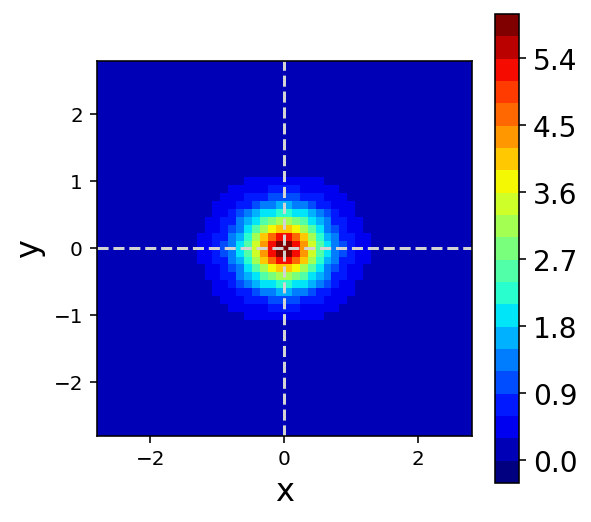

In [4]:
plot_image( data_info['image'], spaceGrid=TF.spaceGrid, xlim=[-2.8, 2.8])

In [5]:
#ImFit = ImageFit(data_info=data_info, active_par_key=['sini', 'r_hl_image', 'theta_int', 'g1', 'g2', 'flux'])
ImFit = ImageFit(data_info=data_info, active_par_key=['sini', 'r_hl_image', 'theta_int', 'flux'])

In [6]:
active_par_test = np.zeros(len(ImFit.active_par_key))
for j, item in enumerate(ImFit.active_par_key):
    active_par_test[j] = ImFit.par_fid[item]
active_par_test

array([5.00000000e-01, 5.00000000e-01, 0.00000000e+00, 5.22303772e+02])

In [7]:
%time loglike = ImFit.cal_loglike(active_par=active_par_test)
loglike

CPU times: user 5.44 ms, sys: 2.84 ms, total: 8.28 ms
Wall time: 5.74 ms


-0.0

In [8]:
chainImage_info = ImFit.run_MCMC(Nwalker=50, Nsteps=1000)

Chain_Image = ChainTool(chainImage_info, Nburn=25000, Nend=50000)

100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]

Total MCMC time (mins): 3.7000435471534727


In [9]:
Chain_Image.par_bestfit(select_par_key=['r_hl_image'], statistics='max', mode=1)

(array([0.50002428]), array([0.00918784]))

In [10]:
from chainconsumer import ChainConsumer

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

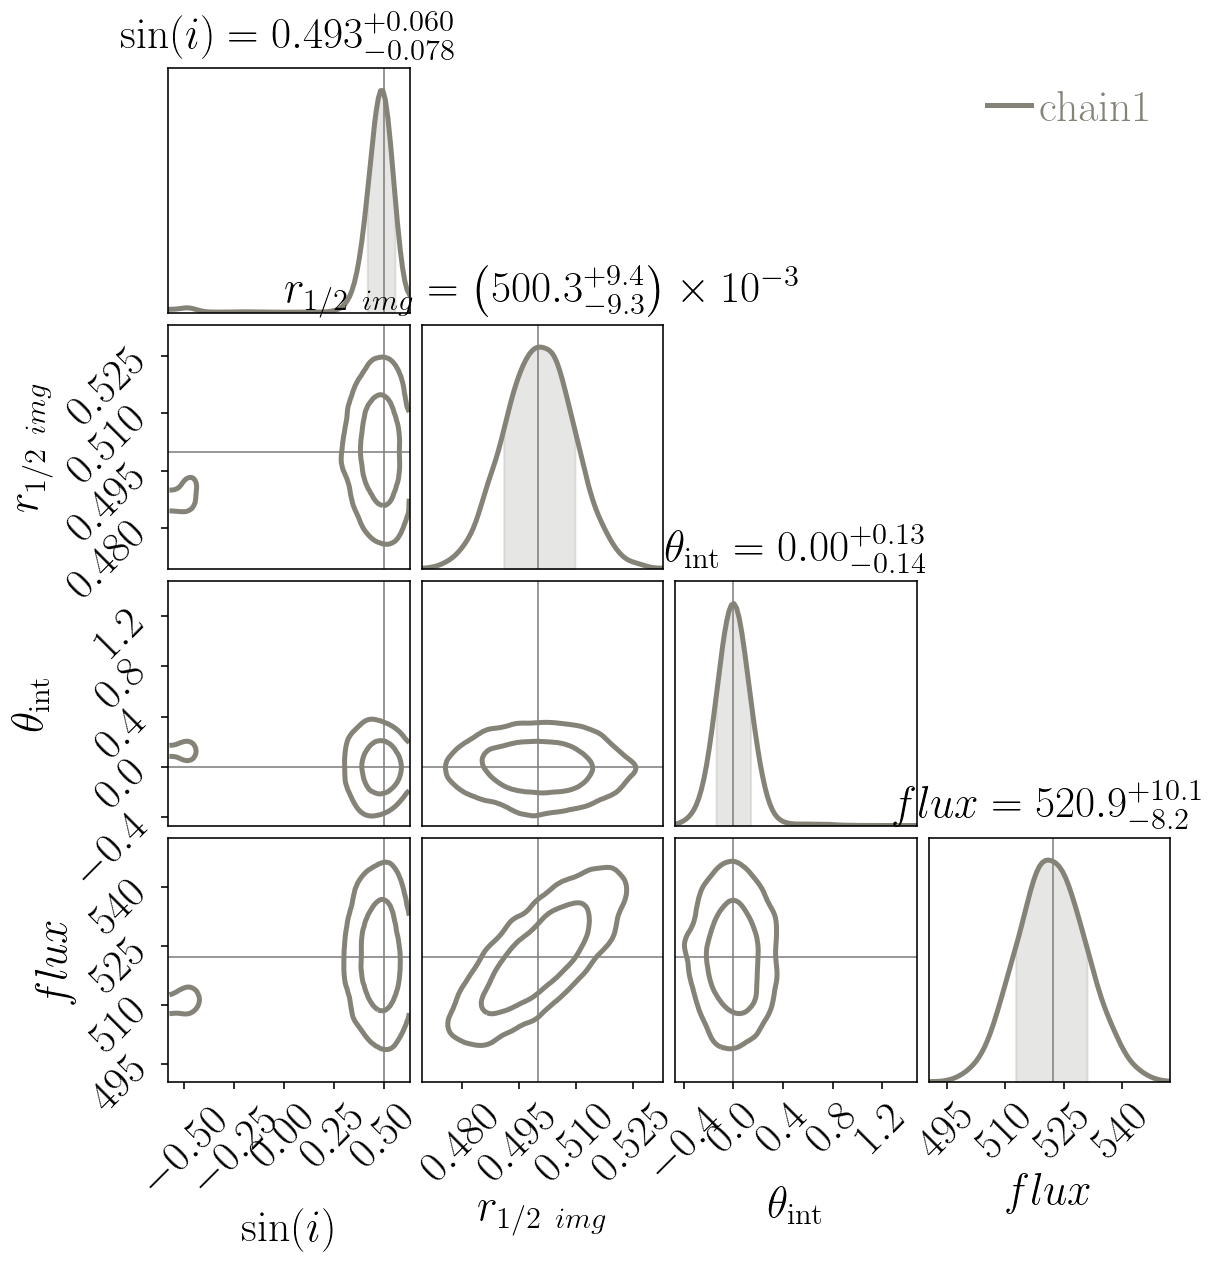

In [11]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['sini','r_hl_image','theta_int','flux']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
truth_pt = [data_info['par_fid'][item] for item in ImFit.active_par_key]
fig = c.plotter.plot(legend=True, truth=truth_pt) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)